# Gas Boiler to heat pump dynamic Material Flow analysis
This doc uses the dynamic_stock_model package

The objective is to replace every boiler by heat pumps by 2050 in Vaud Canton

## Import data

In [144]:
import dynamic_stock_model as dsm 
import numpy as np
import matplotlib.pyplot as plt
import openpyxl


In [145]:
# Vaud number housing
housing_2024= 381144

# increase of the number of housing

housing_increase_2024 = 1/100 # 1/100 is the actual rate

# Proportion of HP
prop_HP_2024 = 0.17
# Proportion of GB
prop_GB_2024 = 0.30

# Lifetime HP
lifetime_HP_2024 = [20]*(61)  # from 2015 to 2050

# Lifetime GB
lifetime_GB_2024 = [20]*(46)  # from 2015 to 2050

# std lifetime 
std_GB=0.25
std_HP=0.25

# density functions
HP_pdf='Normal'
GB_pdf='Normal'

# Define time range
Years = np.arange(2015, 2051) # 2015 to 2025 is the initialisation then 2025 to 2050 is the projection



In [146]:

def polyfit_fixed_last_point(x, y, degree=2):
    """
    Fits a polynomial of a given degree to data, forcing it through the last point.
    """
    # Define the fixed point (last point in the dataset)
    xf, yf = x[-1], y[-1]
    
    # Create the new variables
    y_prime = y - yf
    
    # Construct the design matrix for the new linear system
    # For a 2nd degree polynomial, columns are (x - xf) and (x^2 - xf^2)
    X_prime = np.vstack([x**i - xf**i for i in range(1, degree + 1)]).T
    
    # Solve the linear system for coefficients (a1, a2, ...)
    # np.linalg.lstsq solves A @ b = y for b (here, X_prime @ a_prime = y_prime)
    a_prime, residuals, rank, singular_values = np.linalg.lstsq(X_prime, y_prime, rcond=None)
    
    # Calculate a0 using the constraint equation
    a0 = yf - sum(coeff * (xf**i) for i, coeff in enumerate(a_prime, 1))
    
    # Combine coefficients into the standard order (a2, a1, a0) for np.poly1d
    # Note: np.poly1d expects [a_deg, a_deg-1, ..., a0]
    coeffs_standard_order = np.insert(a_prime, 0, a0)[::-1]
    
    return np.poly1d(coeffs_standard_order), a0, a_prime

## Initial parameters


[5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 47


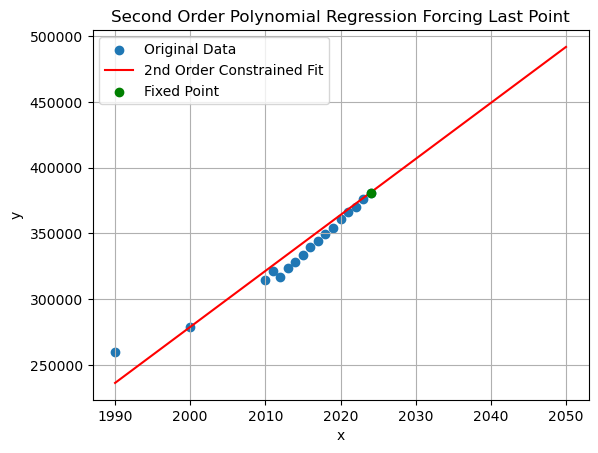

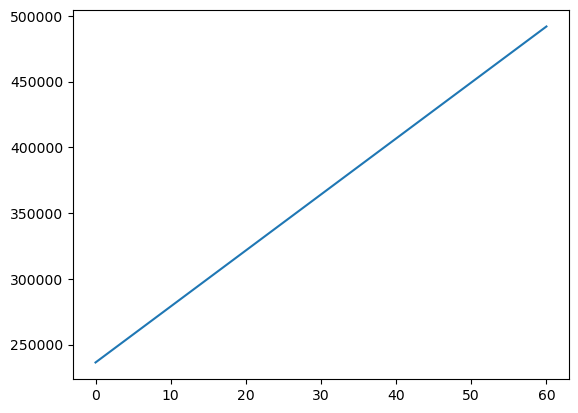

In [147]:
# Use previous import of GB sales in Vaud
GB_sales =[housing_2024*prop_GB_2024/21]*21+[0]*26
print(GB_sales, len(GB_sales))

# Calculate housing increase over time for future years
Dates_housing=[1990, 2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Housing_data=[260060, 278752, 314596, 321158, 317243, 323577, 328414,333955,339882, 344627, 349758, 354496, 360928, 366389, 370394, 376518, housing_2024]

# --- Usage ---
# Sample data
x = np.array(Dates_housing)
y = np.array(Housing_data)

# Perform the constrained fit
polynomial_func, a0, a_prime = polyfit_fixed_last_point(x, y, degree=1)

# Generate points for plotting the curve
x_new = np.arange(1990, 2051)
y_fit = polynomial_func(x_new)

# Plotting
plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_fit, color='red', label='2nd Order Constrained Fit')
plt.scatter(x[-1], y[-1], color='green', zorder=5, label='Fixed Point') # Highlight fixed point
plt.xlabel('x')
plt.ylabel('y')
plt.title('Second Order Polynomial Regression Forcing Last Point')
plt.legend()
plt.grid(True)
plt.show()



Housing=y_fit.tolist()
plt.plot(Housing)

## Create the models

output flow [0.00000000e+00 3.17925197e-01 9.84275910e-01 2.32614146e+00
 4.92237264e+00 9.74857959e+00 1.83683707e+01 3.31599913e+01
 5.75472509e+01 9.61784744e+01 1.54973711e+02 2.40949080e+02
 3.61739968e+02 5.24790611e+02 7.36255896e+02 9.99757867e+02
 1.31522700e+03 1.67810288e+03 2.07914275e+03 2.50498154e+03
 2.93942285e+03 3.36526164e+03 3.76598358e+03 4.12819311e+03
 4.44232038e+03 4.70322612e+03 4.90986520e+03 5.06429605e+03
 5.17029532e+03 5.23188343e+03 5.25204744e+03 5.23188343e+03
 5.17029532e+03 5.06429605e+03 4.90986520e+03 4.70322612e+03
 4.44232038e+03 4.12819311e+03 3.76598358e+03 3.36526164e+03
 2.93956858e+03 2.50519147e+03 2.07937984e+03 1.67835101e+03
 1.31547945e+03 1.00001193e+03 7.36510545e+02]
('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 47 years.<br>Inflow vector is present with 47 years.<br>Total stock is present with 47 years.<br>Stock by cohorts is present with 47 years and 47 cohorts.<br>Total outflow is present wi

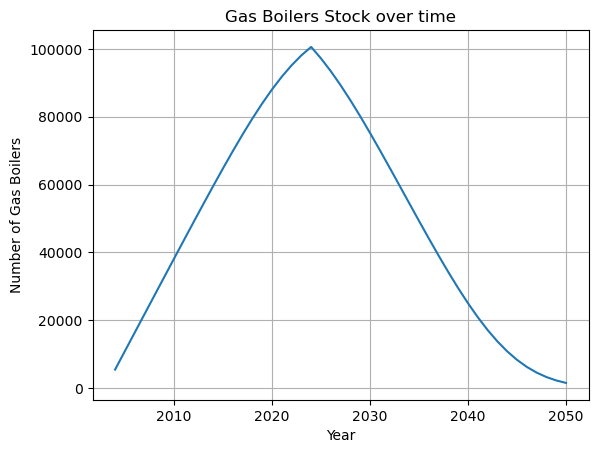

240.9490803029421


In [148]:
# inflow driven model for Gas boilers
# over 2004-2024 and then projection 2025-2050
Years_GB=np.arange(2004,2051)
GB_DSM = dsm.DynamicStockModel(t = Years_GB, 
                               i =GB_sales, lt = {'Type': GB_pdf, 'Mean': lifetime_GB_2024, 'StdDev': std_GB* np.array(lifetime_GB_2024)},)



# compute stock
S_C, O_C= GB_DSM.compute_s_c_inflow_driven()
O_C= GB_DSM.compute_o_c_from_s_c()

S=GB_DSM.compute_stock_total()
O=GB_DSM.compute_outflow_total()
check_GB=GB_DSM.dimension_check()
print("output flow", GB_DSM.o)

# plot stock
print(check_GB)
plt.grid()
plt.plot( GB_DSM.t,GB_DSM.s, label='Gas Boilers Stock')
plt.title('Gas Boilers Stock over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')
plt.show()
print(GB_DSM.o[11])


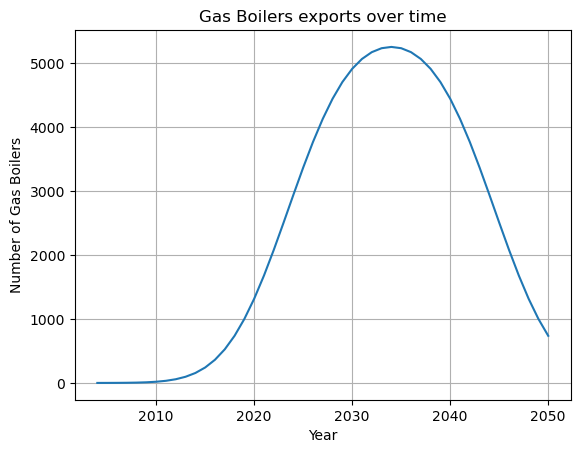

In [149]:
# plot stock

plt.grid()
plt.plot( GB_DSM.t,GB_DSM.o, label='Gas Boilers Stock')
plt.title('Gas Boilers exports over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')
plt.show()

35


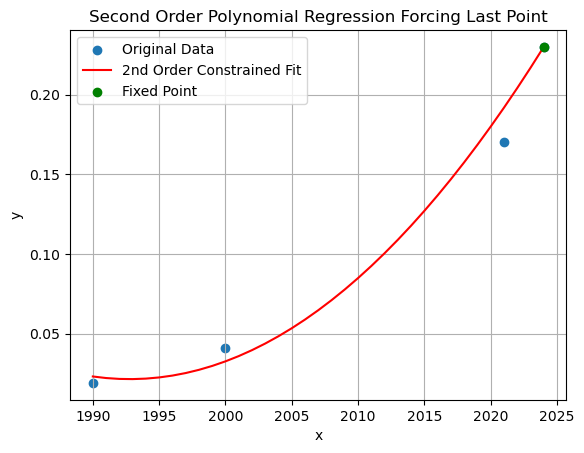

In [150]:
# Model for the heat pumps STOCK driven model
# past stock


Years_HP=np.arange(1990, 2025)
Data_past=[1990, 2000, 2021, 2024]
Data_past_HP=[1.9/100, 4.1/100, 17/100, 23/100]




# --- Usage ---
# Sample data
x = np.array(Data_past)
y = np.array(Data_past_HP)

# Perform the constrained fit
polynomial_func, a0, a_prime = polyfit_fixed_last_point(x, y, degree=2)

# Generate points for plotting the curve
x_new = Years_HP
y_fit = polynomial_func(x_new)
print(len(y_fit))
# Plotting
plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_fit, color='red', label='2nd Order Constrained Fit')
plt.scatter(x[-1], y[-1], color='green', zorder=5, label='Fixed Point') # Highlight fixed point
plt.xlabel('x')
plt.ylabel('y')
plt.title('Second Order Polynomial Regression Forcing Last Point')
plt.legend()
plt.grid(True)
plt.show()

# Print coefficients
# print(f"Coefficients (a0, a1, a2): {a0}, {a_prime[0]}, {a_prime[1]}")
# print(f"Function: {polynomial_func}")


HP_stock_i=[x*h for x,h in zip(y_fit.tolist(),Housing)]

In [151]:
# from 2025 to 2050
H=[HP_stock_i[-1]]*(2050-2024) #63651
Housing_increase=[h-housing_2024 for h in Housing]

GB_to_HP=np.array(GB_DSM.o).cumsum()

HP_stock_f = [a + b + (prop_GB_2024+prop_HP_2024)*hi for a,b,hi in zip(H,GB_to_HP,Housing_increase[-(2050-2024):])]  #  2025 to 2050 is the projection

# total stock
HP_stock= HP_stock_i + HP_stock_f

# add new DSM for heat pumps

HP_DSM = dsm.DynamicStockModel(t = np.arange(1990,2051), 
                               s =HP_stock, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow is not present.<br>Total stock is present with 61 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, '% of Heat pumps')

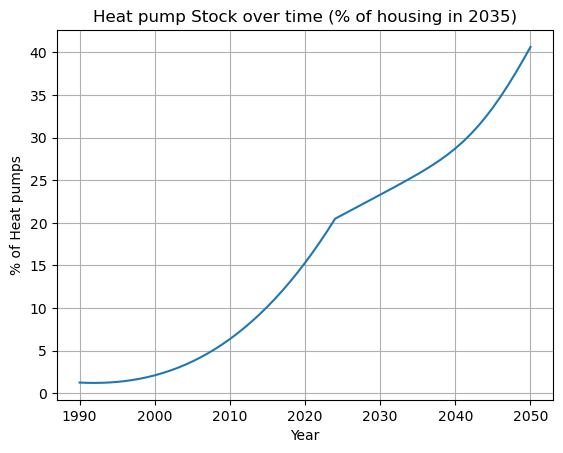

In [152]:
# compute stock driven model to get inflow
check_HP=HP_DSM.dimension_check()
print(check_HP)
I_C1= HP_DSM.compute_stock_driven_model()

S1=HP_DSM.compute_stock_total()


# plot stock

plt.grid()
plt.plot( HP_DSM.t,np.array(HP_DSM.s)/(Housing[-16])*100, label='Heat pump Stock')
plt.title('Heat pump Stock over time (% of housing in 2035)')
plt.xlabel('Year')
plt.ylabel('% of Heat pumps')

Text(0, 0.5, 'Heat pumps')

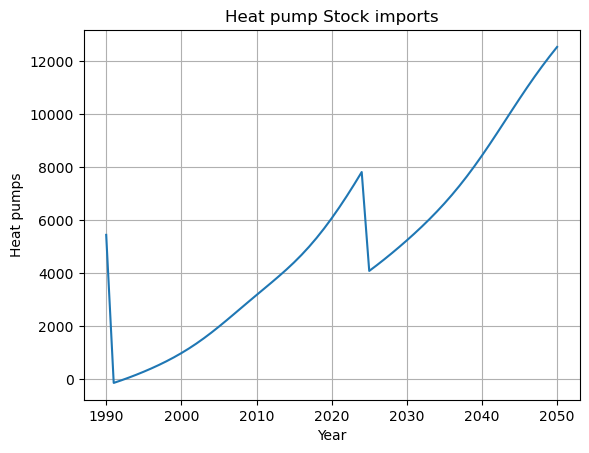

In [153]:
# plot stock

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')
plt.title('Heat pump Stock imports')
plt.xlabel('Year')
plt.ylabel('Heat pumps')

## Calculating an incentive to buy HP 
Target of 55% in 2035(from https://www.sciencedirect.com/science/article/pii/S0301421525002253)

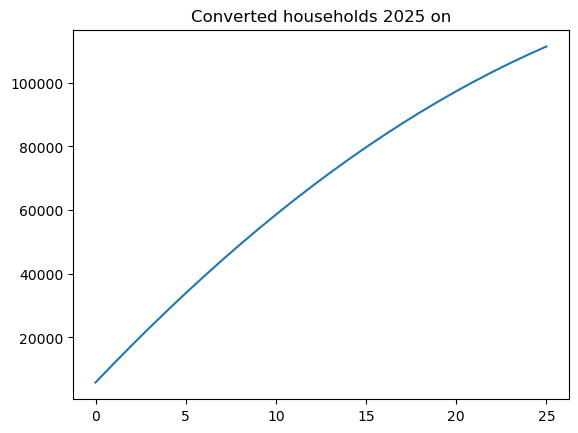

In [154]:
incentive_HP=2/100 #<- result: percentage of households that don't have converted yet but will convert due to incentives

# calculate converted households
Converted_households=[incentive_HP*(housing_2024-HP_stock_i[-1])]

for i in range(1,26):
    Converted_households.append(incentive_HP*(Housing[26-i]-HP_stock[26-i]-Converted_households[-1])+Converted_households[-1])
plt.plot(Converted_households)
plt.title("Converted households 2025 on")

HP_stock_f1 = [a+ b for a,b in zip(HP_DSM.s[-(2050-2024):],Converted_households)]



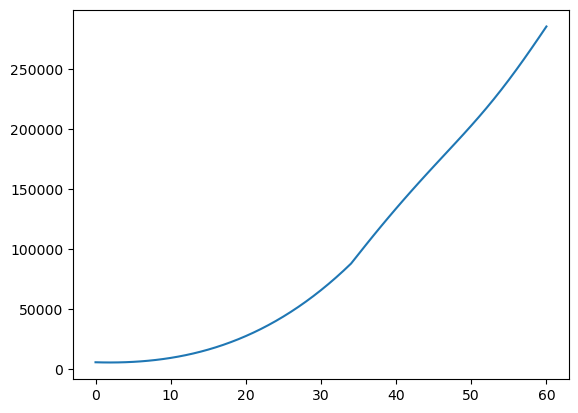

In [155]:

# total stock
HP_stock1= HP_stock_i + HP_stock_f1
plt.plot(HP_stock1)

# add new buildings

HP_DSM_incentive = dsm.DynamicStockModel(t = np.arange(1990, 2051), 
                               s =HP_stock1, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow vector is present with 61 years.<br>Total stock is present with 61 years.<br>Stock by cohorts is present with 61 years and 61 cohorts.<br>Total outflow is present with 61 years.<br>Outflow by cohorts is present with 61 years and 61 cohorts.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


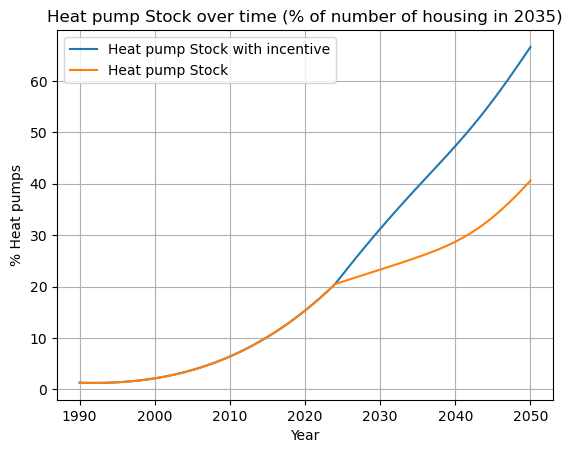

In [156]:
# compute stock driven model to get inflow
HP_inc= HP_DSM_incentive.compute_stock_driven_model()

S_inc=HP_DSM_incentive.compute_stock_total()
O_inc=HP_DSM_incentive.compute_outflow_total()
check_HP_inc=HP_DSM_incentive.dimension_check()
# plot stock
print(check_HP_inc)
plt.grid()
plt.plot( HP_DSM_incentive.t,np.array(HP_DSM_incentive.s)/(Housing[-16])*100, label='Heat pump Stock with incentive')
plt.plot( HP_DSM.t,np.array(HP_DSM.s)/(Housing[-16])*100, label='Heat pump Stock')
plt.title('Heat pump Stock over time (% of number of housing in 2035)')
plt.xlabel('Year')
plt.ylabel('% Heat pumps')
plt.legend()

Text(0, 0.5, 'Heat pumps')

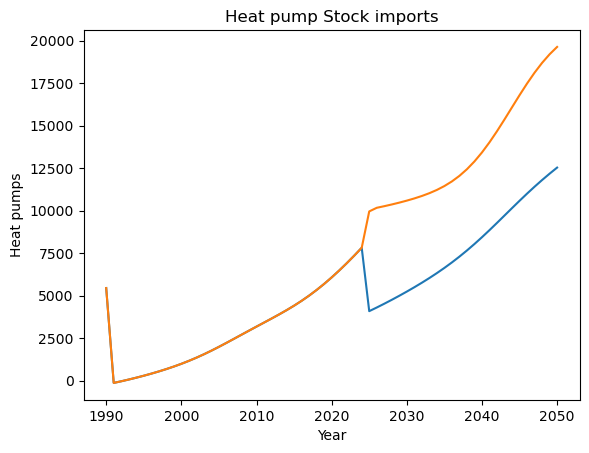

In [157]:
# plot stock

plt.grid()
# plot stock

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')

plt.plot( HP_DSM_incentive.t,HP_DSM_incentive.i, label='Heat pump import with incentive')
plt.title('Heat pump Stock imports')
plt.xlabel('Year')
plt.ylabel('Heat pumps')

# Flow modelling:
electricity import,
gas import,
CO2 emissions,
Copper use, copper waste

In [158]:
# Data

# Household energy consumption
S_household=95 #m2 de surface habitable average
cons_surface=30 #kWh/m² par an

# Heat pump
COP=3.26 # Coefficient of performance

# Gas boiler
LHV_gas= 50 # MJ/kg
efficiency_GB=0.9

# emissions
e_elec= 0.0273 #kgCO2/kWh
e_gas_boiler= 0.0754 #kgCO2/MJ  !!
e_HP_manufacture=1010+81-175 #kgCO2/unit (assembly+transport+End of Life)

# Copper
copper_HP= 25 #kg
copper_GB= 1.5 #kg

## Electricity imports

In [159]:
# electricity needs per household

elec_need_HP= S_household*cons_surface/COP  #kWh/year

# electricity needs total per year
Elec_imports=np.array(HP_DSM.s)*elec_need_HP/1000000  #GWh/year
Elec_imports_inc=np.array(HP_DSM_incentive.s)*elec_need_HP/1000000  #GWh/year
print(Elec_imports)
print(Elec_imports_inc)

[  4.76227816   4.64251947   4.60714412   4.66093296   4.80866679
   5.05512645   5.40509276   5.86334655   6.43466864   7.12383986
   7.93564104   8.874853     9.94625657  11.15463257  12.50476184
  14.00142518  15.64940344  17.45347744  19.418428    21.54903596
  23.85008212  26.32634733  28.98261241  31.82365818  34.85426547
  38.07921511  41.50328791  45.13126472  48.96792635  53.01805363
  57.28642738  61.77782844  66.49703763  71.44883576  76.63800368
  78.38751224  80.13729874  81.88766778  83.63920993  85.39302179
  87.15105288  88.91661968  90.6951178   92.49493607  94.32852704
  96.21351875  98.17367298 100.2394266  102.4477245  104.84089235
 107.46442236 110.36374593 113.58030763 117.14747166 121.08691807
 125.40616746 130.09769923 135.13955539 140.49806713 146.13119933
 151.99242398]
[  4.76227816   4.64251947   4.60714412   4.66093296   4.80866679
   5.05512645   5.40509276   5.86334655   6.43466864   7.12383986
   7.93564104   8.874853     9.94625657  11.15463257  12.5047

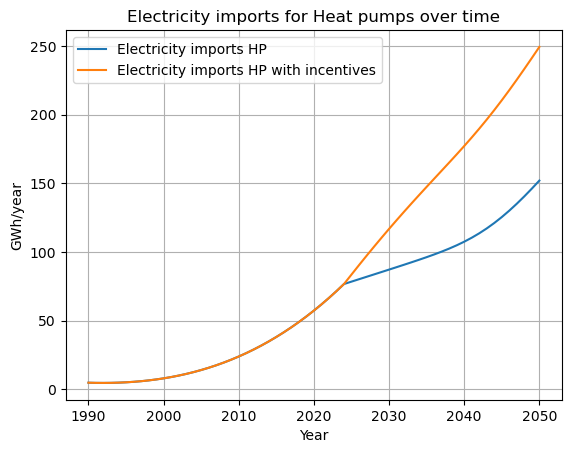

In [160]:
# plot electricity imports
plt.grid()
plt.plot( HP_DSM.t,Elec_imports, label='Electricity imports HP')
plt.plot( HP_DSM_incentive.t,Elec_imports_inc, label='Electricity imports HP with incentives')
plt.title('Electricity imports for Heat pumps over time')
plt.xlabel('Year')
plt.ylabel('GWh/year')
plt.legend()

## Gas imports

In [161]:
# Gas needs per household
gas_need_GB= S_household*cons_surface/(LHV_gas*1000*efficiency_GB)*3600  #kg/year

# gas needs total per year
Gas_imports=np.array(GB_DSM.s[20:])*gas_need_GB/1000000  #kt/year


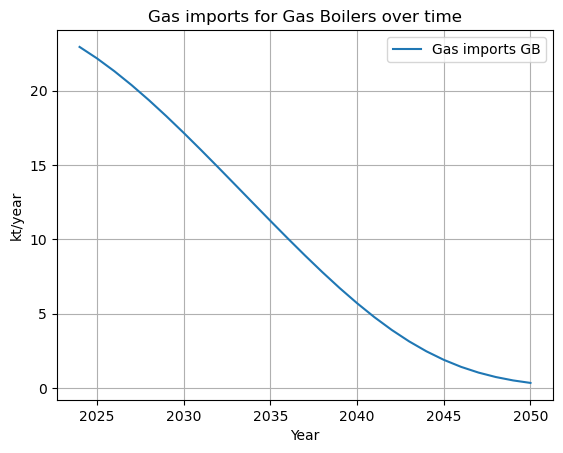

In [162]:
# plot gas imports
plt.grid()
plt.plot( GB_DSM.t[20:],Gas_imports, label='Gas imports GB')
plt.title('Gas imports for Gas Boilers over time')
plt.xlabel('Year')
plt.ylabel('kt/year')
plt.legend()

## $CO_2$ emissions
We use scope 3

In [163]:
# HP $CO_2$ emissions
CO2_emissions_HP= Elec_imports*1000*e_elec + HP_DSM.i*e_HP_manufacture #tCO2/year
CO2_emissions_HP_inc=Elec_imports_inc*1000*e_elec + HP_DSM_incentive.i*e_HP_manufacture #tCO2/year

# GB $CO_2$ emissions
CO2_emissions_GB= S_household*cons_surface*GB_DSM.s[20:]*e_gas_boiler*1000 #tCO2/year

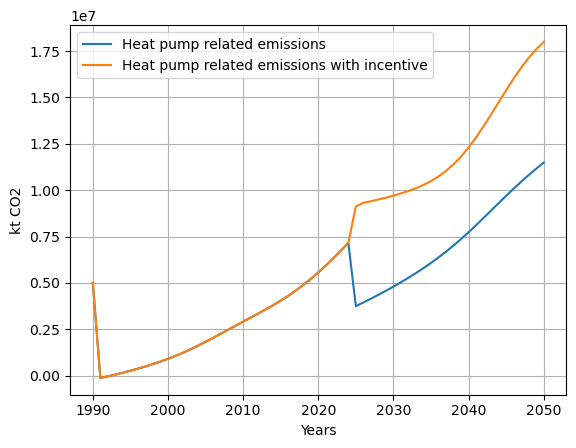

In [164]:
# Plot emissions per energy use per year
plt.grid()
#plt.plot(GB_DSM.t[20:], CO2_emissions_GB, label='Gas boiler related emissions')
plt.plot(HP_DSM.t, CO2_emissions_HP, label='Heat pump related emissions')
plt.plot(HP_DSM_incentive.t, CO2_emissions_HP_inc, label='Heat pump related emissions with incentive')
plt.xlabel('Years')
plt.ylabel('kt CO2')
plt.legend()

## Copper flows

In [165]:
# recycle coefficient
k=0.0

# Copper stocks
Copper_HP_s=np.array(HP_DSM.s)*copper_HP
Copper_HP_inc_s=np.array(HP_DSM_incentive.s)*copper_HP
Copper_GB_s=np.array(GB_DSM.s)*copper_GB

# Copper exports
Copper_HP_o=(1-k)*np.array(HP_DSM.s)*copper_HP

Copper_HP_inc_o=(1-k)*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_o=(1-k)*np.array(GB_DSM.o)*copper_GB

# Copper imports
Copper_HP_i=np.array(HP_DSM.i)*copper_HP-k*np.array(HP_DSM.s)*copper_HP
Copper_HP_inc_i=np.array(HP_DSM_incentive.i)*copper_HP-k*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_i=np.array(GB_DSM.i)*copper_GB-k*np.array(GB_DSM.o)*copper_GB


## Sensitivity analysis